# High level insight on genetic variations
Note: As this is my first published Kernel, am open to suggestions. If this helped you, some upvotes would be very much appreciated.

### Library and Settings
Import required library and define constants

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### Files

Training data size is smaller than testing counterpart. 

### Sneak Peak of data
Load training and testing data. Have a quick look at columns, its shape and values

In [2]:
data_path = "/home/robin/datatsets/msk-redefining-cancer-treatment"
train_variants_df = pd.read_csv(os.path.join(data_path, "training_variants"))
test_variants_df = pd.read_csv(os.path.join(data_path, "test_variants"))
train_text_df = pd.read_csv(os.path.join(data_path, "training_text"), sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv(os.path.join(data_path, "test_text"), sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

print("Train Variant", train_variants_df.shape)
print("Train Text", train_text_df.shape)
print("Test Variant", test_variants_df.shape)
print("Test Text", test_text_df.shape)

Train Variant (3321, 4)
Train Text (3321, 2)
Test Variant (5668, 3)
Test Text (5668, 2)


We have more samples of test data than training data. As mentioned in data introduction, some of the test data is machine-generated to prevent hand labelling.

In [3]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
train_text_df = train_text_df.dropna() 
train_text_df.shape

(3316, 2)

In [5]:
print("For training data, there are a total of") 
print(len(train_variants_df.ID.unique()), "IDs")
print(len(train_variants_df.Gene.unique()), "unique genes,")
print(len(train_variants_df.Variation.unique()), "unique variations")
print(len(train_variants_df.Class.unique()),  "classes")

For training data, there are a total of
3321 IDs
264 unique genes,
2996 unique variations
9 classes


There are 9 classes into which data has to be classified. Lets get the frequency of each class.

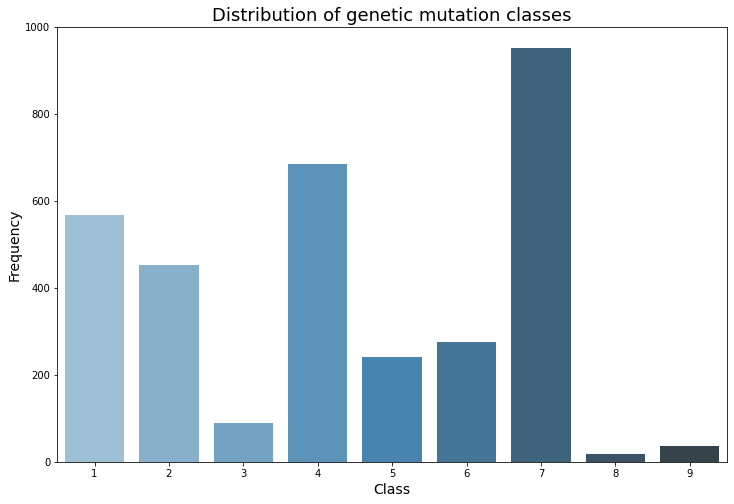

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_variants_df, palette="Blues_d")
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

In [7]:
gene_group = train_variants_df.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences\n", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences\n", minimal_occ_genes)

Genes with maximal occurences
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


Lets have a look at some genes that has highest number of occurrences in each class. 

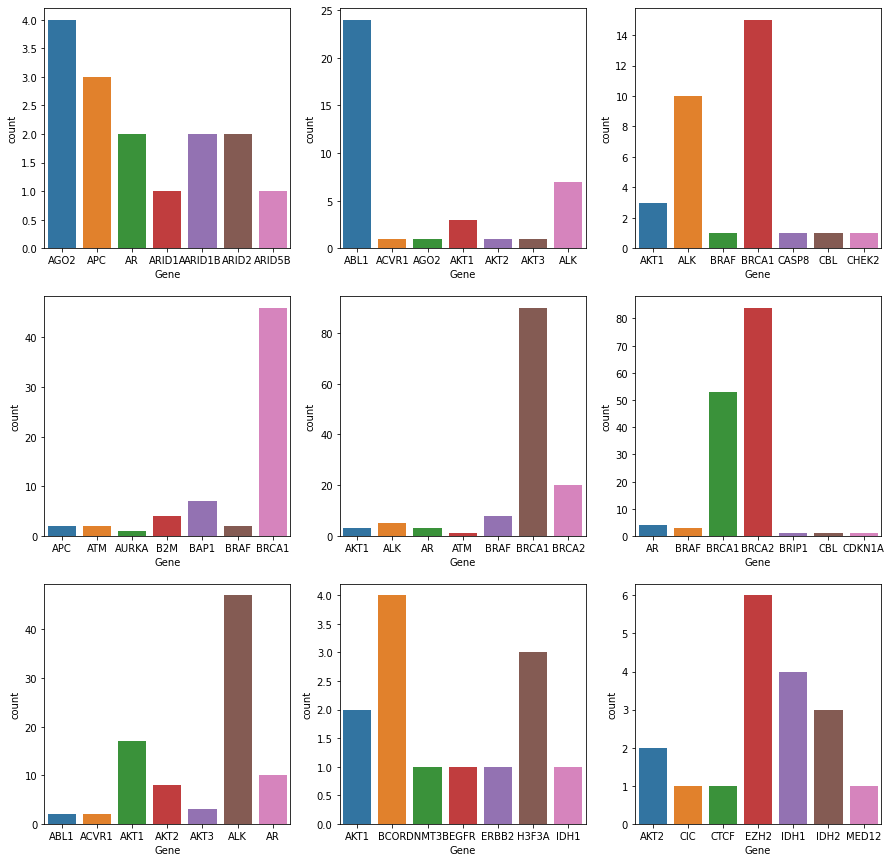

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].size().reset_index(name = "count")
        sorted_gene_group = gene_count_grp.sort_values('count', ascending=False)
        sorted_gene_group_top_7 = gene_count_grp[:7]
        sns.barplot(x="Gene", y="count", data=sorted_gene_group_top_7, ax=axs[i][j])

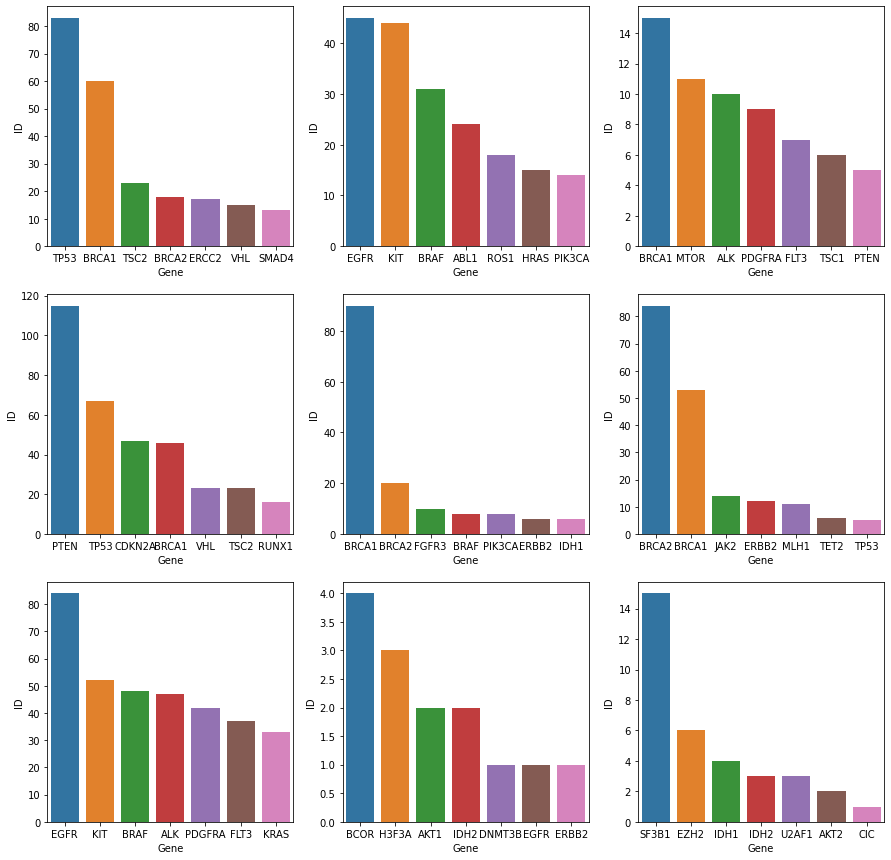

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

Some points we can conclude from these graphs:
 1. BRCA1 is highly dominating Class 5 
 2. SF3B1 is highly dominating Class 9
 3. BRCA1 and BRCA2 are dominating Class 6

## Lets get some insight on text data

In [10]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
train_text_df.shape

(3316, 2)

In [12]:
train_text_df = train_text_df.dropna() 
train_text_df.shape

(3316, 2)

In [13]:
# def func_for(df):
#     for index in df.index:
#         if type(df.loc[index, 'Text']) == str:
#             df.loc[index, 'Text_count'] = len(df.loc[index, 'Text'].split())
#         else:
#             df.loc[index, 'Text_count'] = 1.0
#     return df

In [14]:
# train_text_df = func_for(train_text_df)

In [15]:
train_text_df.loc[:, 'Text_count']  = train_text_df["Text"].apply(lambda x: len(x.split()))
train_text_df.head()

,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


Let us combine both dataframes for further use

In [16]:
train_full = train_variants_df.merge(train_text_df, how="inner", left_on="ID", right_on="ID")
train_full[train_full["Class"]==1].head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cord–stromal tumors and germ-cell tumors a...,2710
38,38,DICER1,D1709A,1,Sex cord–stromal tumors and germ-cell tumors a...,2710


There are multiple rows with similar texts let us check how many of them are unique and whether all similar texts belongs to same class

In [17]:
count_grp = train_full.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,566.0,9483.689046,6503.595573,183.0,4976.00,7317.0,12944.50,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.00,6810.0,12220.00,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.00,5572.0,7415.00,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.00,6351.0,11537.00,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.00,6463.0,9513.50,24226.0
6,273.0,7236.743590,3801.049711,230.0,4691.00,6587.0,7847.00,24609.0
7,952.0,11454.886555,10110.443171,448.0,4876.25,8256.5,14647.25,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.00,11253.0,15535.00,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.00,10930.0,15797.00,45177.0


We can see there are some entries with text count of 1. Lets have a look at those entries

In [18]:
train_full[train_full["Text_count"]==1]

,ID,Gene,Variation,Class,Text,Text_count


In [19]:
train_full[train_full["Text_count"]<500.0]

,ID,Gene,Variation,Class,Text,Text_count
140,140,EGFR,I491M,5,The accurate determination of perfluoroalkyl s...,430
145,145,EGFR,K467T,2,The accurate determination of perfluoroalkyl s...,430
259,259,EGFR,S464L,2,The accurate determination of perfluoroalkyl s...,430
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,228
692,692,CDKN2A,G93W,4,Cell division is controlled by a series of pos...,228
693,693,CDKN2A,V118D,4,Cell division is controlled by a series of pos...,228


As we can see there are some entries without any text data. 
Now let us get distribution of text count for each class

/home/robin/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 61.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robin/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 53.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robin/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robin/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 65.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robin/anaconda3/envs/ml/lib/python3.7/

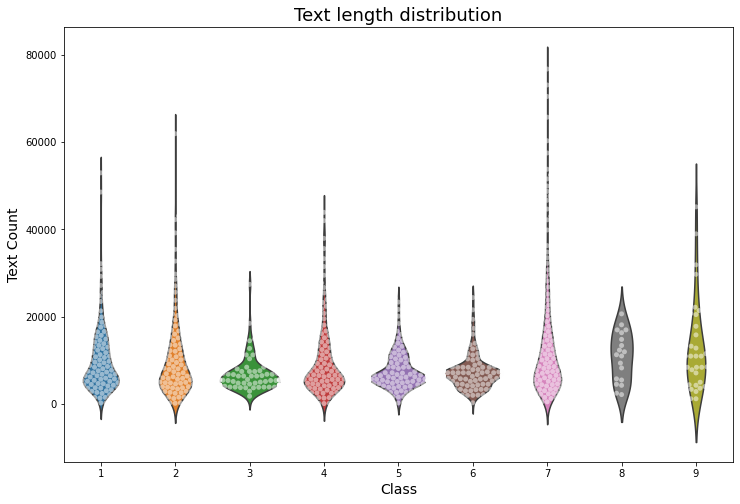

In [20]:
plt.figure(figsize=(12,8))
gene_count_grp = train_full.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=train_full, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=train_full, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

Distribution looks quite interesting and now I am in love with violin plots.
All classes have most counts in between 0 to 20000. Just as expected. 
There should be some 

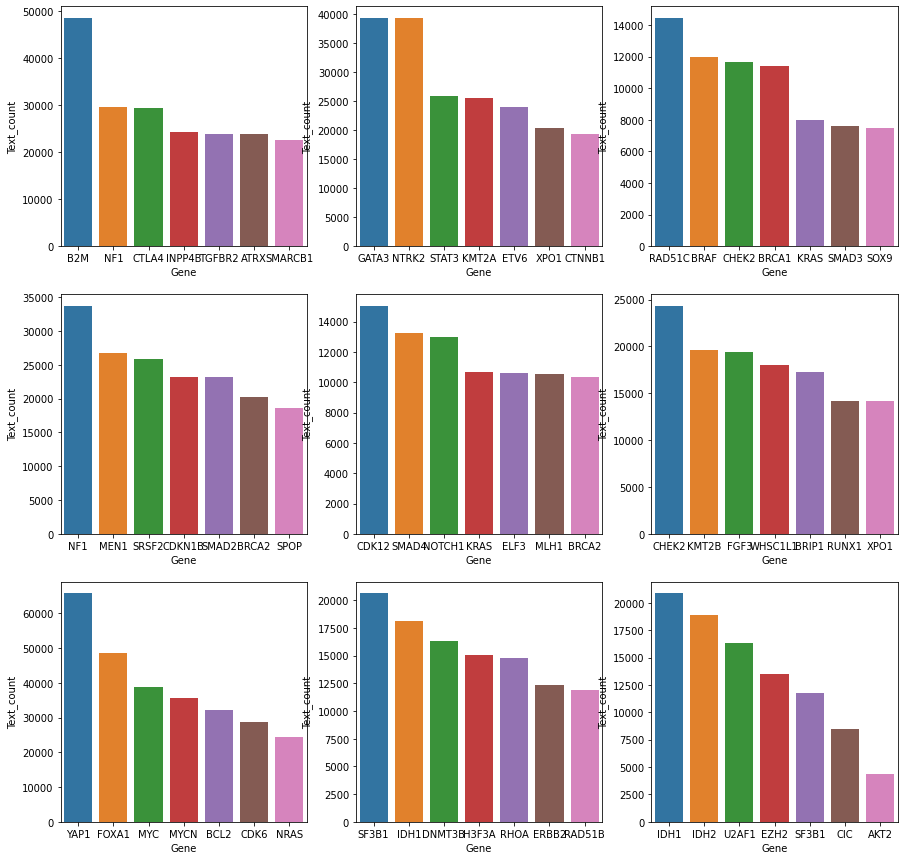

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_full[train_full["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

Frequently occurring terms for each class

We need to know more about text. Tf-idf is known as one good technique to use for text transformation and get good features out of text for training our machine learning model. [Here][1] you can find more details about tf-idf and some useful code snippets. 


  [1]: https://buhrmann.github.io/tfidf-analysis.html

In [22]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

Lets plot out some top features we got using Tf-Idf for each class

In [23]:
tfidf = TfidfVectorizer(
	min_df=5, max_features=16000, strip_accents='unicode',lowercase =True,
	analyzer='word', token_pattern=r'\w+', use_idf=True, 
	smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(train_full["Text"])

Xtr = tfidf.fit_transform(train_full["Text"])
y = train_full["Class"]
features = tfidf.get_feature_names()
top_dfs = top_feats_by_class(Xtr, y, features)

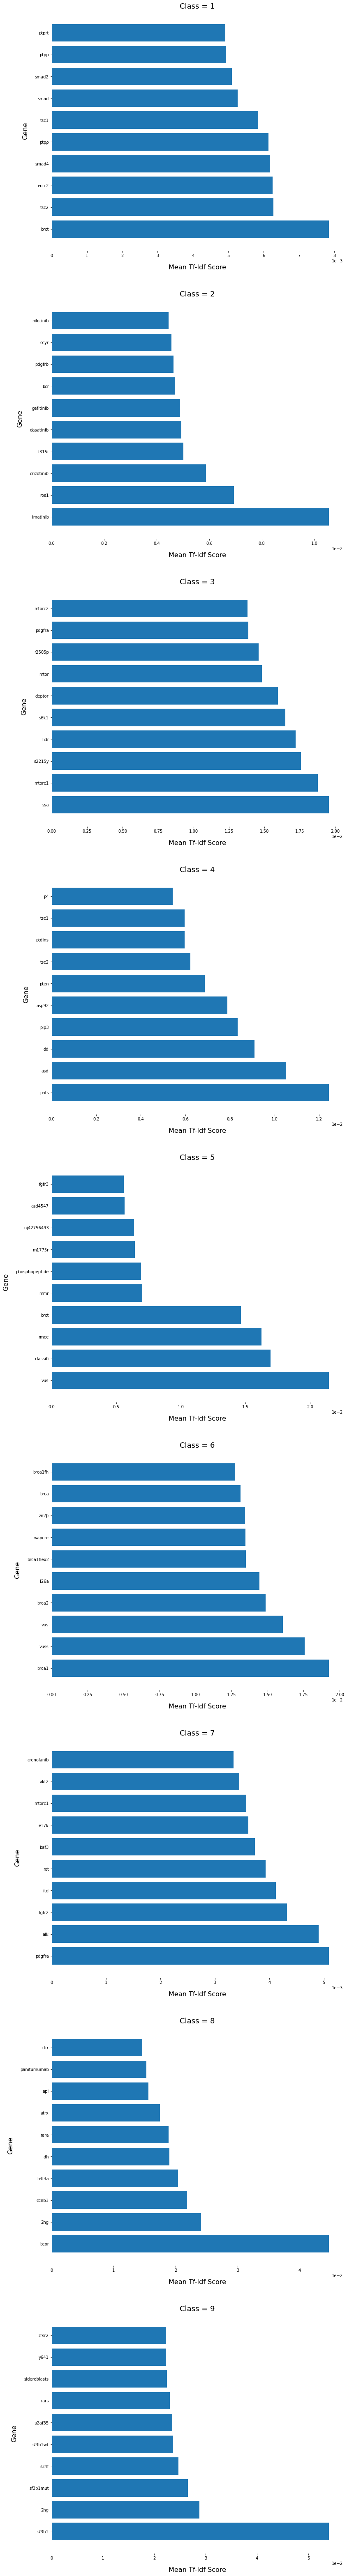

In [24]:
plot_tfidf_classfeats_h(top_dfs)


To be continued...